In [1]:
# Fill in your API token:
sapi_token = ''

In [20]:
# import necessary packages
from sklearn import preprocessing, metrics
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import warnings
warnings.filterwarnings('ignore')

from qboost import QboostPlus

In [3]:
import glob
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [4]:
hot_dogs = glob.glob('./hot-dog-not-hot-dog/*/hot_dog/*.jpg')
not_hot_dogs = glob.glob('./hot-dog-not-hot-dog/*/not_hot_dog/*.jpg')
all_images = hot_dogs + not_hot_dogs
labels = [1 for hot_dog in hot_dogs]+[0 for not_dog in not_hot_dogs]

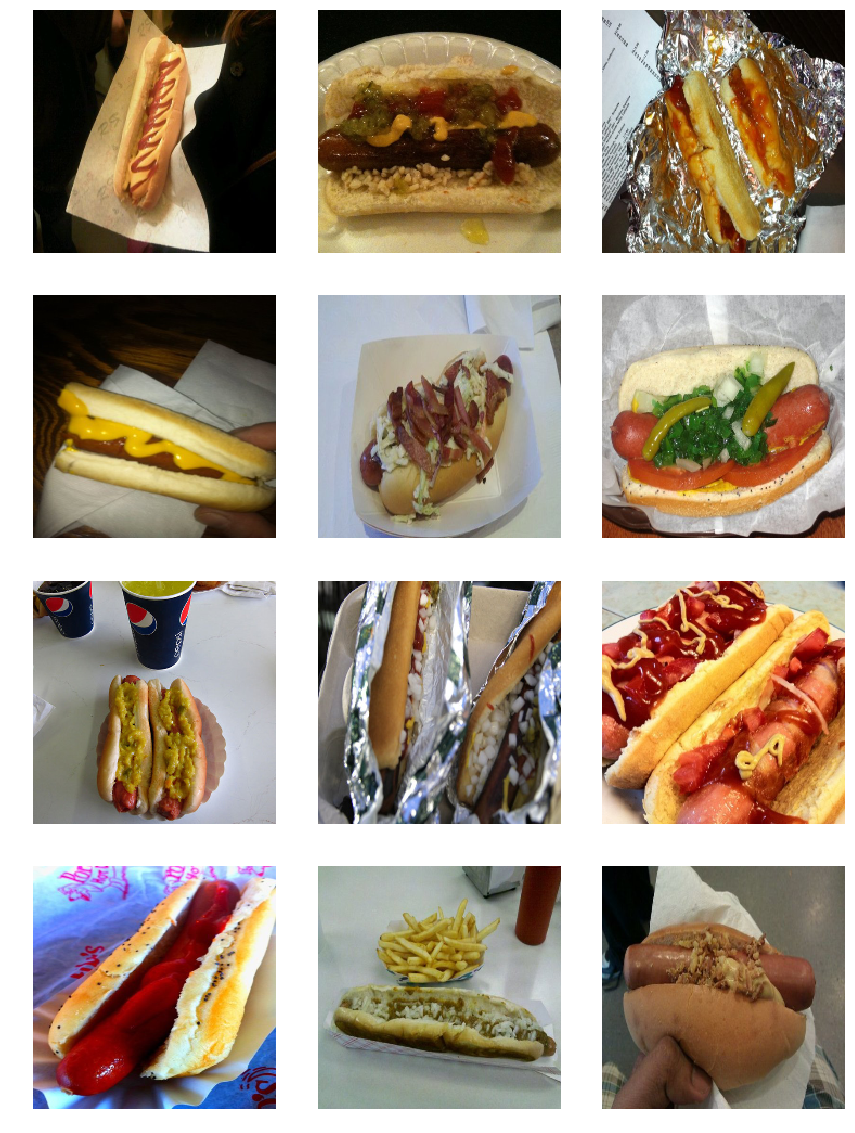

In [5]:
f, axs = plt.subplots(4,3, figsize=(12,16))
f.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    ax.imshow(cv2.resize(imread(hot_dogs[i]),(224,224)))

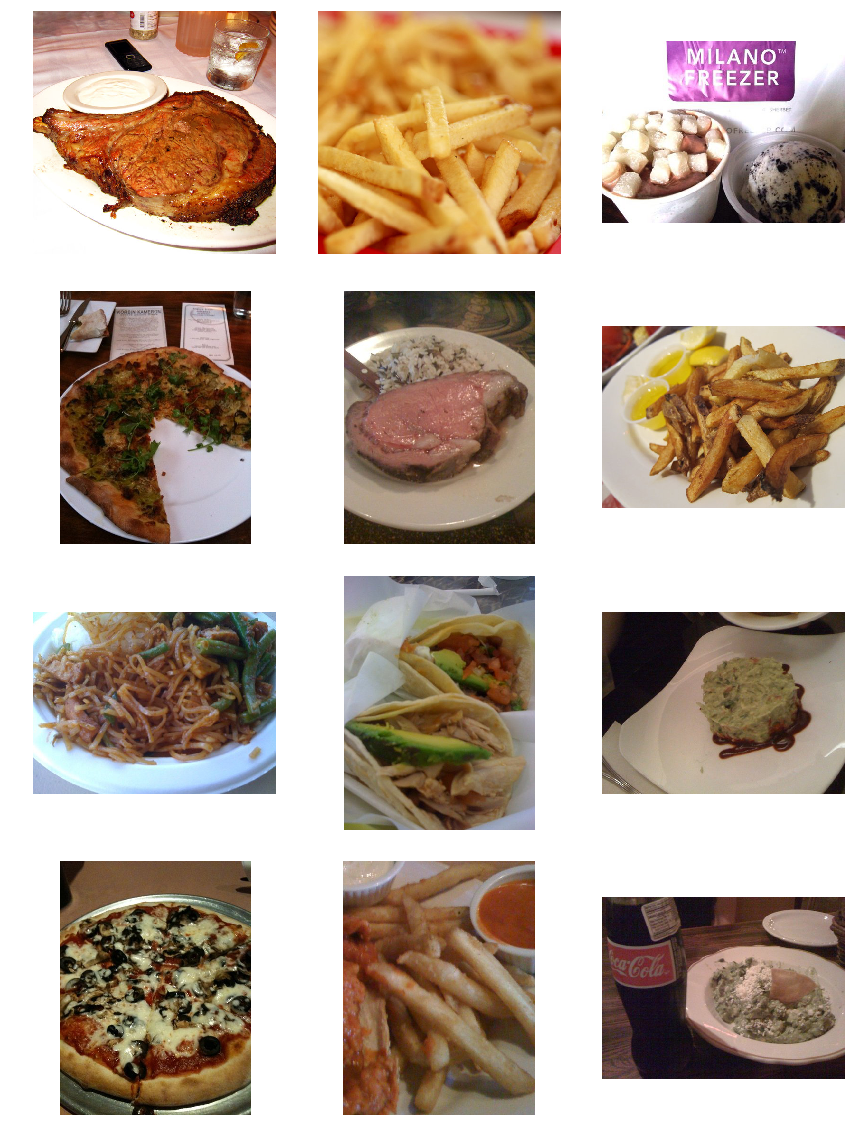

In [6]:
f, axs = plt.subplots(4,3, figsize=(12,16))
f.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    ax.imshow(imread(not_hot_dogs[i]))

In [17]:
# Define the functions required in this example
def metric(y, y_pred):
    """
    :param y: true label
    :param y_pred: predicted label
    :return: metric score
    """

    return metrics.accuracy_score(y, y_pred)


def train_model(X_train, y_train, X_test, y_test, lmd):
    """
    :param X_train: training data
    :param y_train: training label
    :param X_test: testing data
    :param y_test: testing label
    :param lmd: lambda used in regularization
    :return:
    """

    # define parameters used in this function
    NUM_READS = 100
    NUM_WEAK_CLASSIFIERS = 44
    TREE_DEPTH = 3
    DW_PARAMS = {'num_reads': NUM_READS,
                 'auto_scale': True,
                 'num_spin_reversal_transforms': 5,
                 'postprocess': 'optimization',
                 }

    # define sampler
    dwave_sampler = DWaveSampler(token=sapi_token)
    emb_sampler = EmbeddingComposite(dwave_sampler)

    N_train = len(X_train)
    N_test = len(X_test)
    print("\n======================================")
    print("Train size: %d, Test size: %d" %(N_train, N_test))
    print('Num weak classifiers:', NUM_WEAK_CLASSIFIERS)
    
    # LinearSVC
    print('\nLinear SVC')
    clf2 = LinearSVC(C=0.1)
    clf2.fit(X_train, y_train)
    y_train2 = clf2.predict(X_train)
    y_test2 = clf2.predict(X_test)
    print('accu (train): %5.2f' % (metric(y_train, y_train2)))
    print('accu (test): %5.2f' % (metric(y_test, y_test2)))

    print('\nMLP')
    clf4 = MLPClassifier(hidden_layer_sizes=(128,))
    clf4.fit(X_train, y_train)
    y_train4 = clf4.predict(X_train)
    y_test4 = clf4.predict(X_test)
    print('accu (train): %5.2f' % (metric(y_train, y_train4)))
    print('accu (test): %5.2f' % (metric(y_test, y_test4)))
    
    print('\nMLP')
    clf5 = MLPClassifier(hidden_layer_sizes=(96,))
    clf5.fit(X_train, y_train)
    y_train5 = clf5.predict(X_train)
    y_test5 = clf5.predict(X_test)
    print('accu (train): %5.2f' % (metric(y_train, y_train5)))
    print('accu (test): %5.2f' % (metric(y_test, y_test5)))

    # QboostPlus
    print('\nQBoostPlus')
    clf6 = QboostPlus([clf2, clf4, clf5])
    clf6.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)
    y_train6 = clf6.predict(X_train)
    y_test6 = clf6.predict(X_test)
    y_train6 = (y_train6 + 1)//2
    y_test6 = (y_test6 + 1)//2
    print(clf6.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train6)))
    print('accu (test): %5.2f' % (metric(y_test, y_test6)))

    #return [clf1, clf2, clf3, clf4, clf5]

In [8]:
# Currently not using this
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [9]:
hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9)

In [10]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2)

In [11]:
def extract_features(img, flip=False):
    img = cv2.resize(imread(img),(64,64))
    if flip:
        img = np.fliplr(img)
    return np.squeeze(hog.compute(img))

In [12]:
# Build training sets
features = hot_dogs + not_hot_dogs
x_train = [extract_features(img) for img in train_images]
x_train += [extract_features(img, flip=True) for img in train_images]
y_train = train_labels + train_labels
x_test = [extract_features(img) for img in test_images]
x_test += [extract_features(img, flip=True) for img in test_images]
y_test = test_labels + test_labels

In [13]:
# Preprocessing data
scaler = preprocessing.StandardScaler().fit(np.concatenate((x_train,x_test)))
normalizer = preprocessing.Normalizer().fit(np.concatenate((x_train,x_test)))

x_train = scaler.transform(x_train)
x_train = normalizer.transform(x_train)

x_test = scaler.transform(x_test)
x_test = normalizer.transform(x_test)

In [18]:
clfs = train_model(np.array(x_train),
                   np.array(y_train).astype('uint8'),
                   np.array(x_test),
                   np.array(y_test).astype('uint8'),
                   0.2)


Train size: 1596, Test size: 400
Num weak classifiers: 44

Linear SVC
accu (train):  0.77
accu (test):  0.67

MLP
accu (train):  1.00
accu (test):  0.72

MLP
accu (train):  1.00
accu (test):  0.70

QBoostPlus
[1 1 1]
accu (train):  0.87
accu (test):  0.67


In [90]:
# Function to check if an image is a hot dot or not
def is_hot_dog(img, clf):
    features = extract_features(img).reshape(1,-1)
    features = scaler.transform(features)
    features = normalizer.transform(features)
    pred = clf.predict(features)
    if pred:
        return True
    return False

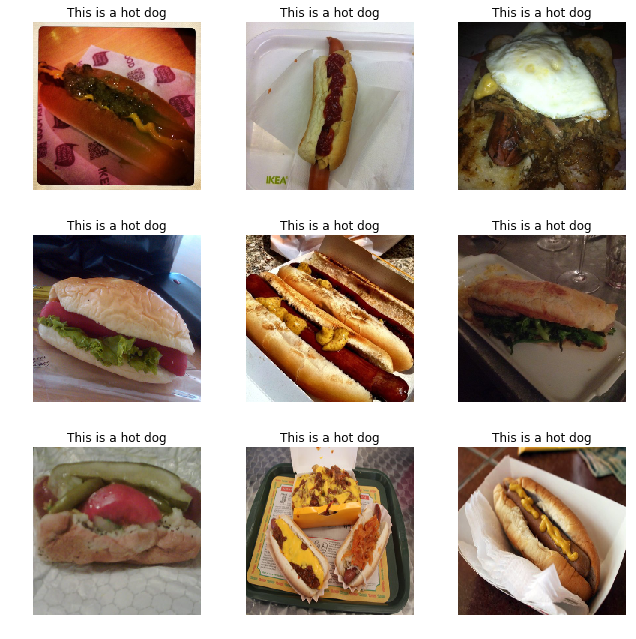

In [110]:
idxs = np.random.randint(0, len(hot_dogs),9)
f, axs = plt.subplots(3,3, figsize=(9,9))
f.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    if is_hot_dog(hot_dogs[idxs[i]],clf6):
        text = "This is a hot dog"
    else:
        text = "This is not a hot dog"
    ax.set_title(str(text))
    ax.imshow(cv2.resize(imread(hot_dogs[idxs[i]]),(224,224)))

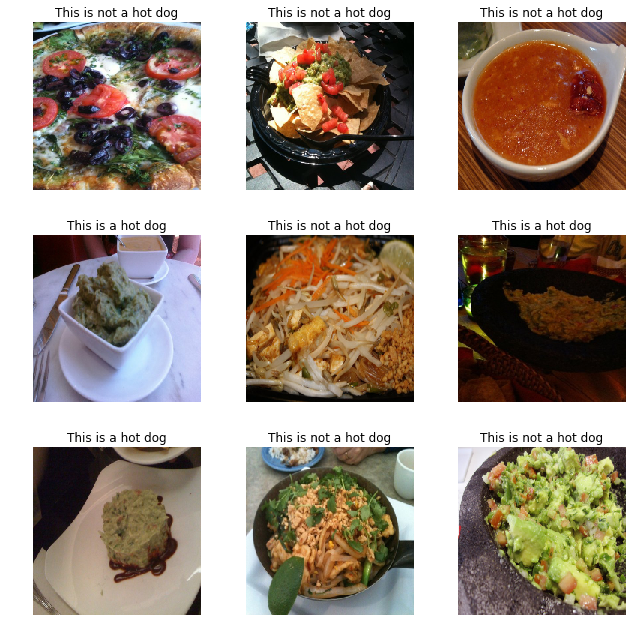

In [108]:
idxs = np.random.randint(0, len(not_hot_dogs),9)
f, axs = plt.subplots(3,3, figsize=(9,9))
f.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    if is_hot_dog(not_hot_dogs[idxs[i]],clf6):
        text = "This is a hot dog"
    else:
        text = "This is not a hot dog"
    ax.set_title(str(text))
    ax.imshow(cv2.resize(imread(not_hot_dogs[idxs[i]]),(224,224)))

In [118]:
# Dump the classifiers
from sklearn.externals import joblib
joblib.dump(normalizer, 'normalizer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(clf2, 'clf2.pkl')
joblib.dump(clf4, 'clf4.pkl')
joblib.dump(clf5, 'clf5.pkl')

['clf5.pkl']